In [1]:
import tensorflow as tf
import h5py
import numpy as np
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
import math
%matplotlib inline

/home/mrigank/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mrigank/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mrigank/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mrigank/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) 
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 
    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 
    classes = np.array(test_dataset["list_classes"][:])
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
x_train,y_train,x_test,y_test,classes=load_dataset()

y = 5


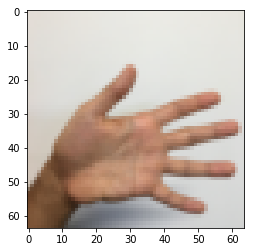

In [4]:
index = 0
plt.imshow(x_train[index])
print ("y = " + str(np.squeeze(y_train[:, index])))

In [5]:
x_train=x_train.reshape(x_train.shape[0],-1).T
x_test=x_test.reshape(x_test.shape[0],-1).T
x_train=x_train/255
x_test=x_test/255

In [6]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [7]:
y_train=convert_to_one_hot(y_train,6)
y_test=convert_to_one_hot(y_test,6)

In [8]:
y_train.shape

(6, 1080)

In [9]:
def create_placeholders(n_x,n_y):
    X=tf.placeholder(tf.float32,shape=[n_x,None],name='X')
    Y=tf.placeholder(tf.float32,shape=[n_y,None],name='Y')
    return X,Y

In [10]:
def initialize_parameters():
    W1=tf.get_variable("W1",shape=[25,12288],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [25, 1], initializer=tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [12, 1], initializer=tf.zeros_initializer())
    W3 = tf.get_variable("W3", [6, 12], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [6, 1], initializer=tf.zeros_initializer())
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    return parameters

In [11]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    Z1 = tf.add(tf.matmul(W1, X), b1)                                             
    A1 = tf.nn.relu(Z1)                                             
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                          
    A2 = tf.nn.relu(Z2)                                              
    Z3 = tf.add(tf.matmul(W3, A2), b3)                                              
    return Z3

In [12]:
def compute_cost(Z3,Y):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    return cost

In [13]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    m = X.shape[1]          
    mini_batches = []
    np.random.seed(seed)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches

In [16]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    ops.reset_default_graph()           
    tf.set_random_seed(1)                             
    seed = 3                                          
    (n_x, m) = X_train.shape                          
    n_y = Y_train.shape[0]                            
    costs = []
    x,y=create_placeholders(n_x,n_y)
    parameters=initialize_parameters()
    Z3=forward_propagation(x,parameters)
    cost=compute_cost(Z3,y)
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init=tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):

            epoch_cost = 0.                     
            num_minibatches = int(m / minibatch_size) 
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, cost], 
                                             feed_dict={x: minibatch_X, 
                                                        y: minibatch_Y})
                epoch_cost += minibatch_cost / num_minibatches

            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        parameters=sess.run(parameters)
        print("Parameters have been trained")
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Train Accuracy:", accuracy.eval({x: X_train, y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({x: X_test, y: Y_test}))
        return parameters

Cost after epoch 0: 1.855702
Cost after epoch 100: 1.016458
Cost after epoch 200: 0.733102
Cost after epoch 300: 0.572941
Cost after epoch 400: 0.468689
Cost after epoch 500: 0.380945
Cost after epoch 600: 0.313824
Cost after epoch 700: 0.254157
Cost after epoch 800: 0.203809
Cost after epoch 900: 0.166347
Cost after epoch 1000: 0.141407
Cost after epoch 1100: 0.107523
Cost after epoch 1200: 0.086226
Cost after epoch 1300: 0.059357
Cost after epoch 1400: 0.052197


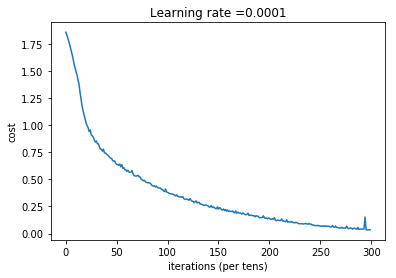

Parameters have been trained
Train Accuracy: 0.9990741
Test Accuracy: 0.71666664


In [17]:
parameters=model(x_train,y_train,x_test,y_test)

In [18]:
def predict(X, parameters):
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    x = tf.placeholder("float", [12288, None])
    z3 = forward_propagation(x, params)
    p = tf.argmax(z3)
    with tf.Session() as sess:
        prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [19]:
y_predict=predict(x_test,parameters)

In [20]:
y_predict

array([1, 0, 0, 5, 1, 0, 3, 1, 4, 1, 5, 1, 3, 1, 1, 3, 3, 5, 0, 4, 5, 4,
       2, 5, 0, 5, 4, 2, 1, 2, 5, 1, 0, 5, 1, 1, 0, 5, 5, 3, 0, 3, 0, 2,
       5, 1, 1, 1, 0, 3, 4, 1, 2, 0, 4, 0, 4, 0, 4, 5, 1, 4, 2, 4, 5, 3,
       0, 2, 3, 3, 0, 4, 3, 2, 5, 4, 3, 5, 1, 5, 2, 0, 1, 5, 2, 4, 4, 1,
       4, 5, 4, 0, 0, 4, 4, 4, 3, 5, 4, 2, 2, 2, 0, 5, 4, 3, 0, 1, 5, 4,
       1, 3, 2, 4, 2, 1, 1, 3, 1, 0])